<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#House-Prices-Prediction-with-pipline-+-Optuna" data-toc-modified-id="House-Prices-Prediction-with-pipline-+-Optuna-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>House Prices Prediction with pipline + Optuna</a></span></li><li><span><a href="#1.-Data-preparation" data-toc-modified-id="1.-Data-preparation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>1. Data preparation</a></span></li><li><span><a href="#2.-Target-setting" data-toc-modified-id="2.-Target-setting-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>2. Target setting</a></span></li><li><span><a href="#3.-Model" data-toc-modified-id="3.-Model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>3. Model</a></span></li><li><span><a href="#4.-Submission" data-toc-modified-id="4.-Submission-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>4. Submission</a></span></li></ul></div>

# House Prices Prediction with pipline + Optuna

https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data

In [1]:
!pip install feature_engine

  Obtaining dependency information for feature_engine from https://files.pythonhosted.org/packages/62/60/77fcc9d3cfaabab34027aa8ea0025c5e2d4cf9561fa9725a38f0785b43aa/feature_engine-1.6.2-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.9/328.9 kB 9.9 MB/s eta 0:00:00


In [2]:
import os
import math
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import optuna
import category_encoders as ce

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.preprocessing import scale
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingRegressor

from imblearn.pipeline import make_pipeline as make_imblearn_pipeline

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from feature_engine.selection import DropCorrelatedFeatures, DropConstantFeatures

from scipy import stats
from scipy import special

# 1. Data preparation

**Description of columns**

**SalePrice** - the property's sale price in dollars. This is the target variable tto predict.

MSSubClass: The building class

MSZoning: The general zoning classification

LotFrontage: Linear feet of street connected to property

LotArea: Lot size in square feet

Street: Type of road access

Alley: Type of alley access

LotShape: General shape of property

LandContour: Flatness of the property

Utilities: Type of utilities available

LotConfig: Lot configuration

LandSlope: Slope of property

Neighborhood: Physical locations within Ames city limits

Condition1: Proximity to main road or railroad

Condition2: Proximity to main road or railroad (if a second is present)

BldgType: Type of dwelling

HouseStyle: Style of dwelling

OverallQual: Overall material and finish quality

OverallCond: Overall condition rating

YearBuilt: Original construction date

YearRemodAdd: Remodel date

RoofStyle: Type of roof

RoofMatl: Roof material

Exterior1st: Exterior covering on house

Exterior2nd: Exterior covering on house (if more than one material)

MasVnrType: Masonry veneer type

MasVnrArea: Masonry veneer area in square feet

ExterQual: Exterior material quality

ExterCond: Present condition of the material on the exterior

Foundation: Type of foundation

BsmtQual: Height of the basement

BsmtCond: General condition of the basement

BsmtExposure: Walkout or garden level basement walls

BsmtFinType1: Quality of basement finished area

BsmtFinSF1: Type 1 finished square feet

BsmtFinType2: Quality of second finished area (if present)

BsmtFinSF2: Type 2 finished square feet

BsmtUnfSF: Unfinished square feet of basement area

TotalBsmtSF: Total square feet of basement area

Heating: Type of heating

HeatingQC: Heating quality and condition

CentralAir: Central air conditioning

Electrical: Electrical system

1stFlrSF: First Floor square feet

2ndFlrSF: Second floor square feet

LowQualFinSF: Low quality finished square feet (all floors)

GrLivArea: Above grade (ground) living area square feet

BsmtFullBath: Basement full bathrooms

BsmtHalfBath: Basement half bathrooms

FullBath: Full bathrooms above grade

HalfBath: Half baths above grade

Bedroom: Number of bedrooms above basement level

Kitchen: Number of kitchens

KitchenQual: Kitchen quality

TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)

Functional: Home functionality rating

Fireplaces: Number of fireplaces

FireplaceQu: Fireplace quality

GarageType: Garage location

GarageYrBlt: Year garage was built

GarageFinish: Interior finish of the garage

GarageCars: Size of garage in car capacity

GarageArea: Size of garage in square feet

GarageQual: Garage quality

GarageCond: Garage condition
PavedDrive: Paved driveway

WoodDeckSF: Wood deck area in square feet

OpenPorchSF: Open porch area in square feet

EnclosedPorch: Enclosed porch area in square feet

3SsnPorch: Three season porch area in square feet

ScreenPorch: Screen porch area in square feet

PoolArea: Pool area in square feet

PoolQC: Pool quality

Fence: Fence quality

MiscFeature: Miscellaneous feature not covered in other categories

MiscVal: $Value of miscellaneous feature

MoSold: Month Sold

YrSold: Year Sold

SaleType: Type of sale

SaleCondition: Condition of sale


In [3]:
# data download 
train0 = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
test0 = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")

train0.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
test0.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [5]:
train0.shape

(1460, 81)

In [6]:
train0.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [7]:
test0.shape

(1459, 80)

In [8]:
test0.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

There is no 'SalePrice' column intest dataframe.

In [9]:
data0=pd.concat([train0,test0],axis=0)

data0.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,2919.000000,2919.000000,2433.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2896.000000,2918.000000,...,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,1460.000000
mean,1460.000000,57.137718,69.305795,10168.114080,6.089072,5.564577,1971.312778,1984.264474,102.201312,441.423235,...,93.709832,47.486811,23.098321,2.602261,16.062350,2.251799,50.825968,6.213087,2007.792737,180921.195890
std,842.787043,42.517628,23.344905,7886.996359,1.409947,1.113131,30.291442,20.894344,179.334253,455.610826,...,126.526589,67.575493,64.244246,25.188169,56.184365,35.663946,567.402211,2.714762,1.314964,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,730.500000,20.000000,59.000000,7478.000000,5.000000,5.000000,1953.500000,1965.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129975.000000
50%,1460.000000,50.000000,68.000000,9453.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,368.500000,...,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,2189.500000,70.000000,80.000000,11570.000000,7.000000,6.000000,2001.000000,2004.000000,164.000000,733.000000,...,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,2919.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000,755000.000000


In [10]:
data0.isna().sum()

Id                  0
MSSubClass          0
MSZoning            4
LotFrontage       486
LotArea             0
                 ... 
MoSold              0
YrSold              0
SaleType            1
SaleCondition       0
SalePrice        1459
Length: 81, dtype: int64

In [11]:
data0.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [12]:
def labelencoder(df):
    for c in df.columns:
        if df[c].dtype=='object': 
            df[c] = df[c].fillna('unknown')
            lbl = LabelEncoder()
            lbl.fit(list(df[c].values))
            df[c] = lbl.transform(df[c].values)
    return df

In [13]:
data=labelencoder(data0)

train=data.iloc[0:len(train0)]
test=data.iloc[len(train0):]

After operation of function labelencoder remains NA  in the numeric columns, we will fill it by KNN inputer methos below.

# 2. Target setting

In [14]:
y_train = train['SalePrice']

X_train = train.drop('SalePrice',axis=1)

X_test = test.drop('SalePrice',axis=1)

Boxcox transformation of target

In [15]:
transformed_data, lambda_value = stats.boxcox(y_train)

boxcox_y_train = pd.DataFrame(transformed_data, index=y_train.index)

boxcox_y_train.head()

,0
0,7.932610
1,7.878263
2,7.959618
3,7.774955
4,8.002875


Comparision of target distribution curves before and after boxcox transformation

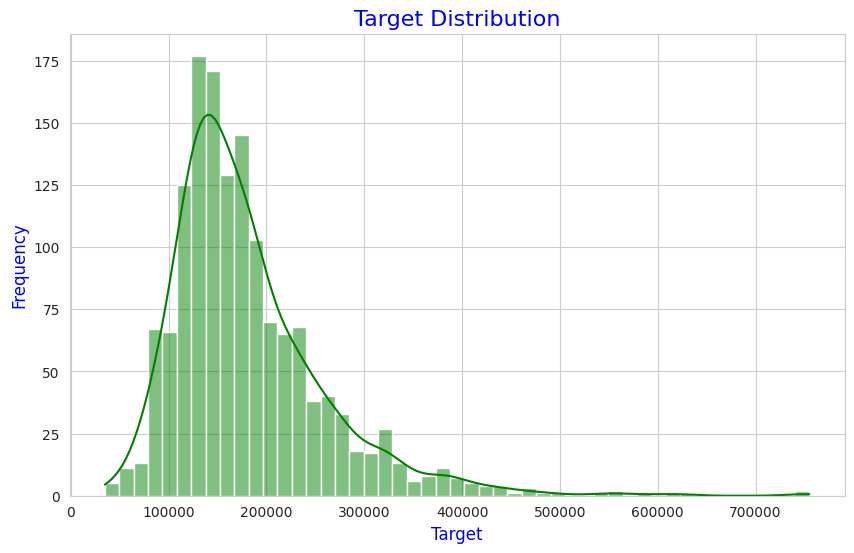

In [16]:
# Plot the distribution in the dataset
plt.figure(figsize=(10, 6))
sns.set_style('whitegrid')
sns.set_palette('inferno')
sns.histplot(y_train, kde=True, color='g')
plt.xlabel('Target', fontsize=12, color='b')
plt.ylabel('Frequency', fontsize=12, color='b')
plt.title('Target Distribution', fontsize=16, color='b')
plt.show()

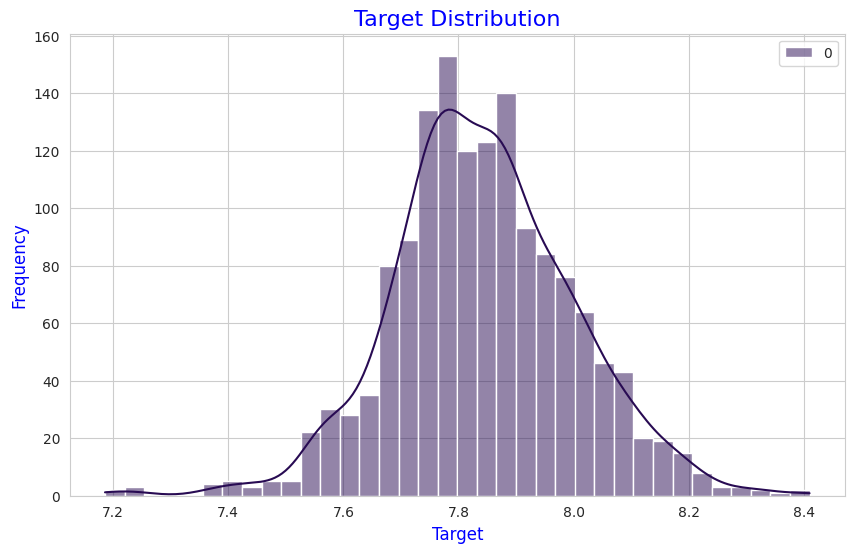

In [17]:
# Plot the distribution in the dataset after boxcox
plt.figure(figsize=(10, 6))
sns.set_style('whitegrid')
sns.set_palette('inferno')
sns.histplot(boxcox_y_train, kde=True, color='g')
plt.xlabel('Target', fontsize=12, color='b')
plt.ylabel('Frequency', fontsize=12, color='b')
plt.title('Target Distribution', fontsize=16, color='b')
plt.show()

# 3. Model

The is no categorical colums after encoding

In [18]:
cat_colunmns = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

Numeric columns are columns of all dataframe

In [19]:
non_binary_numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).nunique() > 2

num_columns = non_binary_numeric_cols[non_binary_numeric_cols].index.tolist()

In [20]:
scaler = StandardScaler()
# poly = PolynomialFeatures()
drop_correlation = DropCorrelatedFeatures(threshold=0.9)

# t_encoder = TargetEncoder()

num_pipeline = make_imblearn_pipeline(scaler,
                                      KNNImputer(),
                                      # poly,
                                      drop_correlation)

# cat_pipeline = make_imblearn_pipeline(t_encoder,
                                      # scaler,
                                      # KNNImputer(),
                                      # poly,
                                      # drop_correlation)
                                      

column_transformer = make_column_transformer((num_pipeline, num_columns),
#                                            (cat_pipeline, cat_colunmns),
                                              remainder='passthrough')

column_transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler()),
                                                 ('knnimputer', KNNImputer()),
                                                 ('dropcorrelatedfeatures',
                                                  DropCorrelatedFeatures(threshold=0.9))]),
                                 ['Id', 'MSSubClass', 'MSZoning', 'LotFrontage',
                                  'LotArea', 'Alley', 'LotShape', 'LandContour',
                                  'LotConfig', 'LandSlope', 'Neighborhood',
                                  'Condition1', 'Condition2', 'BldgType',
                                  'HouseStyle', 'OverallQual', 'OverallCond',
                                  'YearBuilt', 'YearRemodAdd', 'RoofStyle',
                                  'RoofMatl', 'Exterior1st', 'Exterior2nd',
                                  'MasVnrType', 'MasVnrArea', 'ExterQual',
                                  'ExterCond', 'Foundation', 'BsmtQual',
                                  'BsmtCond', ...])])

In [21]:
pipeline = make_imblearn_pipeline(column_transformer,
#                                 FunctionSampler(func=outlier_detector_), 
                                  DropConstantFeatures(),
                                  )

In [22]:
%%time

# Using column_transformer for boxcox_y_train
pipeline.fit(X_train, boxcox_y_train)

CPU times: user 439 ms, sys: 285 ms, total: 724 ms
Wall time: 286 ms


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('knnimputer',
                                                                   KNNImputer()),
                                                                  ('dropcorrelatedfeatures',
                                                                   DropCorrelatedFeatures(threshold=0.9))]),
                                                  ['Id', 'MSSubClass',
                                                   'MSZoning', 'LotFrontage',
                                                   'LotArea', 'Alley',
                                                   'LotShape', 'LandContour',
                                                   'LotConfig', 'LandSlope',
                                                   'Neighborhood', 'Condition1',
                                                   'Condition2', 'BldgType',
                                                   'HouseStyle', 'OverallQual',
                                                   'OverallCond', 'YearBuilt',
                                                   'YearRemodAdd', 'RoofStyle',
                                                   'RoofMatl', 'Exterior1st',
                                                   'Exterior2nd', 'MasVnrType',
                                                   'MasVnrArea', 'ExterQual',
                                                   'ExterCond', 'Foundation',
                                                   'BsmtQual', 'BsmtCond', ...])])),
                ('dropconstantfeatures', DropConstantFeatures())])

In [23]:
# To output transformed matrices for further hyperparameter tuning using the Optuna library

X_train_transformed = pipeline.transform(X_train)

X_train_transformed_df = pd.DataFrame(X_train_transformed)

X_train_transformed_df.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x70,x71,x72,x73,x74,x75,x76,x77,x78,x79
0,-1.730865,0.073375,-0.045532,-0.208034,-0.207142,0.244717,0.750731,0.314667,0.604670,-0.225716,...,0.457447,0.191594,-0.087688,-1.599111,0.138777,0.313867,0.208502,1.0,0.0,1.0
1,-1.728492,-0.872563,-0.045532,0.409895,-0.091886,0.244717,0.750731,0.314667,-0.628316,-0.225716,...,0.457447,0.191594,-0.087688,-0.489110,-0.614439,0.313867,0.208502,1.0,0.0,1.0
2,-1.726120,0.073375,-0.045532,-0.084449,0.073480,0.244717,-1.378933,0.314667,0.604670,-0.225716,...,0.457447,0.191594,-0.087688,0.990891,0.138777,0.313867,0.208502,1.0,0.0,1.0
3,-1.723747,0.309859,-0.045532,-0.414011,-0.096897,0.244717,-1.378933,0.314667,-1.861302,-0.225716,...,0.457447,0.191594,-0.087688,-1.599111,-1.367655,0.313867,-3.426284,1.0,0.0,1.0
4,-1.721374,0.073375,-0.045532,0.574676,0.375148,0.244717,-1.378933,0.314667,-0.628316,-0.225716,...,0.457447,0.191594,-0.087688,2.100892,0.138777,0.313867,0.208502,1.0,0.0,1.0


In [24]:
%%time

def objective(trial):
    # Define parameters
    lgbm_params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-2, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 5, 25),
        "n_estimators": trial.suggest_int("n_estimators", 50, 1000),
        "n_jobs": -1,
        "num_leaves": trial.suggest_int("num_leaves", 5, 31),
    }
    
    # Define a model with parameters
    model = LGBMRegressor(**lgbm_params, random_state=301023, verbose=-1, force_row_wise=True)
    
    # Calculate RMSE on cross-validation
    rmse_scores = np.sqrt(-cross_val_score(model, X_train_transformed, boxcox_y_train, 
                                          scoring='neg_mean_squared_error', cv=3))
    rmse = np.mean(rmse_scores)
    
    return rmse

# Optuna optimization loop
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Best results
best_params_lgbm = study.best_params
best_rmse_lgbm = study.best_value
print(f"Best hyperparameters: {best_params_lgbm}")
print(f"Best RMSE through cross-validation: {best_rmse_lgbm}")

[I 2023-11-13 21:27:38,862] A new study created in memory with name: no-name-2d4b4599-afb2-452a-86e1-e8ae0196b8f6
[I 2023-11-13 21:27:40,789] Trial 0 finished with value: 0.053645781995155746 and parameters: {'learning_rate': 0.03695446162695562, 'max_depth': 23, 'n_estimators': 220, 'num_leaves': 12}. Best is trial 0 with value: 0.053645781995155746.
[I 2023-11-13 21:27:43,630] Trial 1 finished with value: 0.05327452292188977 and parameters: {'learning_rate': 0.047947942004226654, 'max_depth': 21, 'n_estimators': 416, 'num_leaves': 10}. Best is trial 1 with value: 0.05327452292188977.
[I 2023-11-13 21:27:45,794] Trial 2 finished with value: 0.05294255268519493 and parameters: {'learning_rate': 0.07253883622236948, 'max_depth': 23, 'n_estimators': 610, 'num_leaves': 5}. Best is trial 2 with value: 0.05294255268519493.
[I 2023-11-13 21:27:49,602] Trial 3 finished with value: 0.0536684153369911 and parameters: {'learning_rate': 0.03848938270367071, 'max_depth': 11, 'n_estimators': 425, '

Best hyperparameters: {'learning_rate': 0.04531692034840028, 'max_depth': 23, 'n_estimators': 803, 'num_leaves': 5}
Best RMSE through cross-validation: 0.052125744138300754
CPU times: user 4min 46s, sys: 2min 21s, total: 7min 7s
Wall time: 4min 15s


In [25]:
# shows the scores from all trials
optuna.visualization.plot_optimization_history(study)

In [26]:
### shows the evolution of the search
optuna.visualization.plot_slice(study)

In [27]:
### optuna.visualization.plot_param_importances 
optuna.visualization.plot_param_importances(study)

Best model

In [28]:
lgbm = LGBMRegressor(**best_params_lgbm, random_state=42, verbose=0, force_row_wise=True) 

In [29]:
ens_pipeline = make_imblearn_pipeline(column_transformer,
#                                 FunctionSampler(func=outlier_detector_), 
                                  DropConstantFeatures(),
                                  VotingRegressor(estimators=[# ('tree', tree),
                                                              ('lgbm', lgbm),
                                                              # ('ridge', ridge),
                                                              # ('xgb', xgb)
                                                             ]))
                           

# adding of ensemble name
ens_pipeline.steps[-1] = ('ensemble', ens_pipeline.steps[-1][1])

In [30]:
ens_pipeline.fit(X_train, boxcox_y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('knnimputer',
                                                                   KNNImputer()),
                                                                  ('dropcorrelatedfeatures',
                                                                   DropCorrelatedFeatures(threshold=0.9))]),
                                                  ['Id', 'MSSubClass',
                                                   'MSZoning', 'LotFrontage',
                                                   'LotArea', 'Alley',
                                                   'LotShape', 'LandContour',
                                                   'LotConfig'...
                                                   'RoofMatl', 'Exterior1st',
                                                   'Exterior2nd', 'MasVnrType',
                                                   'MasVnrArea', 'ExterQual',
                                                   'ExterCond', 'Foundation',
                                                   'BsmtQual', 'BsmtCond', ...])])),
                ('dropconstantfeatures', DropConstantFeatures()),
                ('ensemble',
                 VotingRegressor(estimators=[('lgbm',
                                              LGBMRegressor(force_row_wise=True,
                                                            learning_rate=0.04531692034840028,
                                                            max_depth=23,
                                                            n_estimators=803,
                                                            num_leaves=5,
                                                            random_state=42,
                                                            verbose=0))]))])

# 4. Submission

In [31]:
predictions = ens_pipeline.predict(X_test)

In [32]:
original_data = special.inv_boxcox(predictions, lambda_value)

original_data

array([114966.96713317, 154058.66114307, 183505.76012306, ...,
       167432.58705056, 119398.62694308, 241401.10192677])

In [33]:
submission = pd.concat([X_test['Id'], pd.Series(original_data, name='SalePrice')], axis=1)

submission.head()

,Id,SalePrice
0,1461,114966.967133
1,1462,154058.661143
2,1463,183505.760123
3,1464,190994.294342
4,1465,178476.533273


In [34]:
submission.to_csv('/kaggle/working/submission.csv',index=False, header=True)

# 5. Conclusion

Submission shows RMSE equal to 0.12832. 

This is baseline model. Possible way for improvement is features engineering.